# Chapter 16: Bayesian statistics

Robert Johansson

Source code listings for [Numerical Python - A Practical Techniques Approach for Industry](http://www.apress.com/9781484205549) (ISBN 978-1-484205-54-9).

The source code listings can be downloaded from http://www.apress.com/9781484205549

In [1]:
import pymc3 as mc
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import pandas as pd

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Changelog:

* 160828: The keyword argument `vars` to the functions `mc.traceplot` and `mc.forestplot` was changed to `varnames`.

# Simple example: Normal distributed random variable

In [9]:
# try this
print(dir(mc.distributions))

['AR', 'AR1', 'AsymmetricLaplace', 'BART', 'Bernoulli', 'Beta', 'BetaBinomial', 'Binomial', 'Bound', 'Categorical', 'Cauchy', 'ChiSquared', 'Constant', 'ConstantDist', 'Continuous', 'DensityDist', 'Dirichlet', 'DirichletMultinomial', 'Discrete', 'DiscreteUniform', 'DiscreteWeibull', 'Distribution', 'ExGaussian', 'Exponential', 'Flat', 'GARCH11', 'Gamma', 'GaussianRandomWalk', 'Geometric', 'Gumbel', 'HalfCauchy', 'HalfFlat', 'HalfNormal', 'HalfStudentT', 'HyperGeometric', 'Interpolated', 'InverseGamma', 'KroneckerNormal', 'Kumaraswamy', 'LKJCholeskyCov', 'LKJCorr', 'Laplace', 'Logistic', 'LogitNormal', 'Lognormal', 'MatrixNormal', 'Mixture', 'MixtureSameFamily', 'Moyal', 'Multinomial', 'MvGaussianRandomWalk', 'MvNormal', 'MvStudentT', 'MvStudentTRandomWalk', 'NegativeBinomial', 'NoDistribution', 'Normal', 'NormalMixture', 'OrderedLogistic', 'OrderedProbit', 'Pareto', 'Poisson', 'Rice', 'Simulator', 'SkewNormal', 'StudentT', 'TensorType', 'Triangular', 'TruncatedNormal', 'Uniform', 'VonM

In [11]:
np.random.seed(10)

In [12]:
mu = 4.0
sigma = 2.0

In [13]:
model = mc.Model()

In [14]:
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [15]:
model.vars

[X ~ Normal]

In [16]:
start = dict(X=2.4)

In [18]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, start=start, cores=4)

/tmp/ipykernel_5567/325050929.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = mc.sample(10000, step=step, start=start, cores=4)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [19]:
x = np.linspace(-4, 12, 1000)

In [20]:
y = stats.norm(mu, sigma).pdf(x)

In [21]:
X = trace.get_values("X")

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


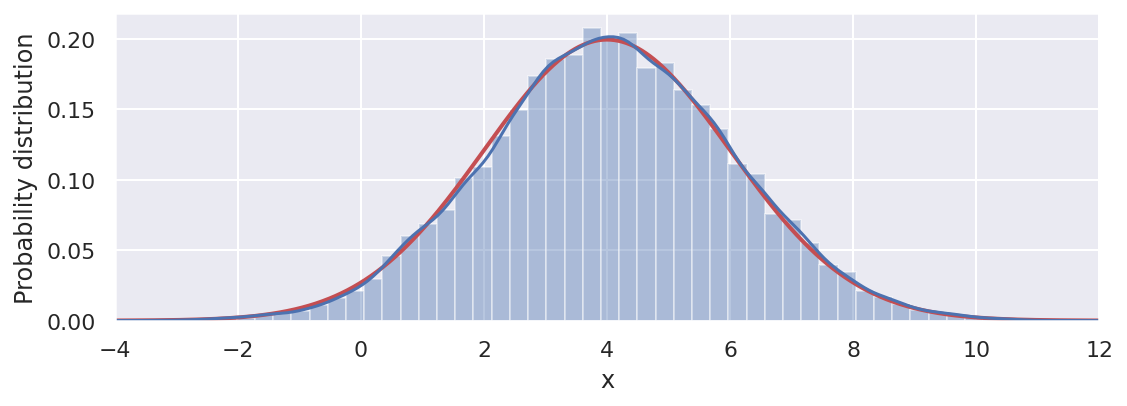

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
# fig.savefig("ch16-normal-distribution-sampled.pdf")

In [30]:
import arviz as ar

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


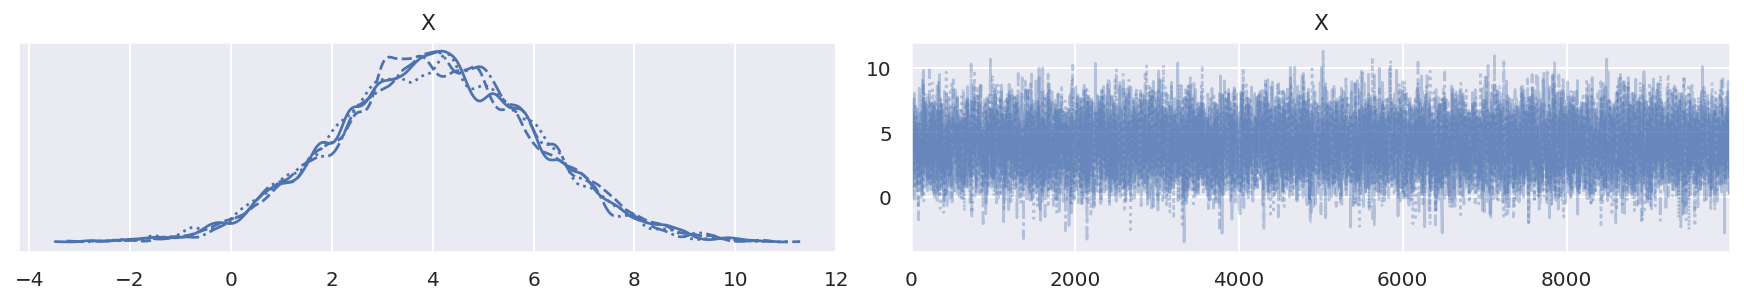

In [40]:
# fig, axes = plt.subplots(figsize=(8, 4), squeeze=False)
mc.plot_trace(trace)
# axes[0,0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()
# fig.savefig("ch16-normal-sampling-trace.png")
# fig.savefig("ch16-normal-sampling-trace.pdf")

## Dependent random variables

In [41]:
model = mc.Model()

In [42]:
with model:
    mean = mc.Normal('mean', 3.5)
    sigma = mc.HalfNormal('sigma', sd=1.3)
    X = mc.Normal('X', mean, tau=sigma)

In [43]:
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution, X ~ Normal]

In [46]:
with model:
    start = mc.find_MAP()

start

{'mean': array(3.5),
 'sigma_log__': array(-0.08420939),
 'X': array(3.5),
 'sigma': array(0.91923876)}

In [47]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, start=start, step=step, cores=4)

/tmp/ipykernel_5567/3513175337.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = mc.sample(10000, start=start, step=step, cores=4)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [X]
>Metropolis: [sigma]
>Metropolis: [mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 101 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [48]:
trace.get_values('sigma').mean()

1.0196985249196733

In [51]:
X = trace.get_values('X')

In [52]:
X.mean()

3.5833194986490846

In [54]:
trace.get_values('X').std()

2.707560990906216

/tmp/ipykernel_5567/634674960.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  mc.traceplot(trace)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


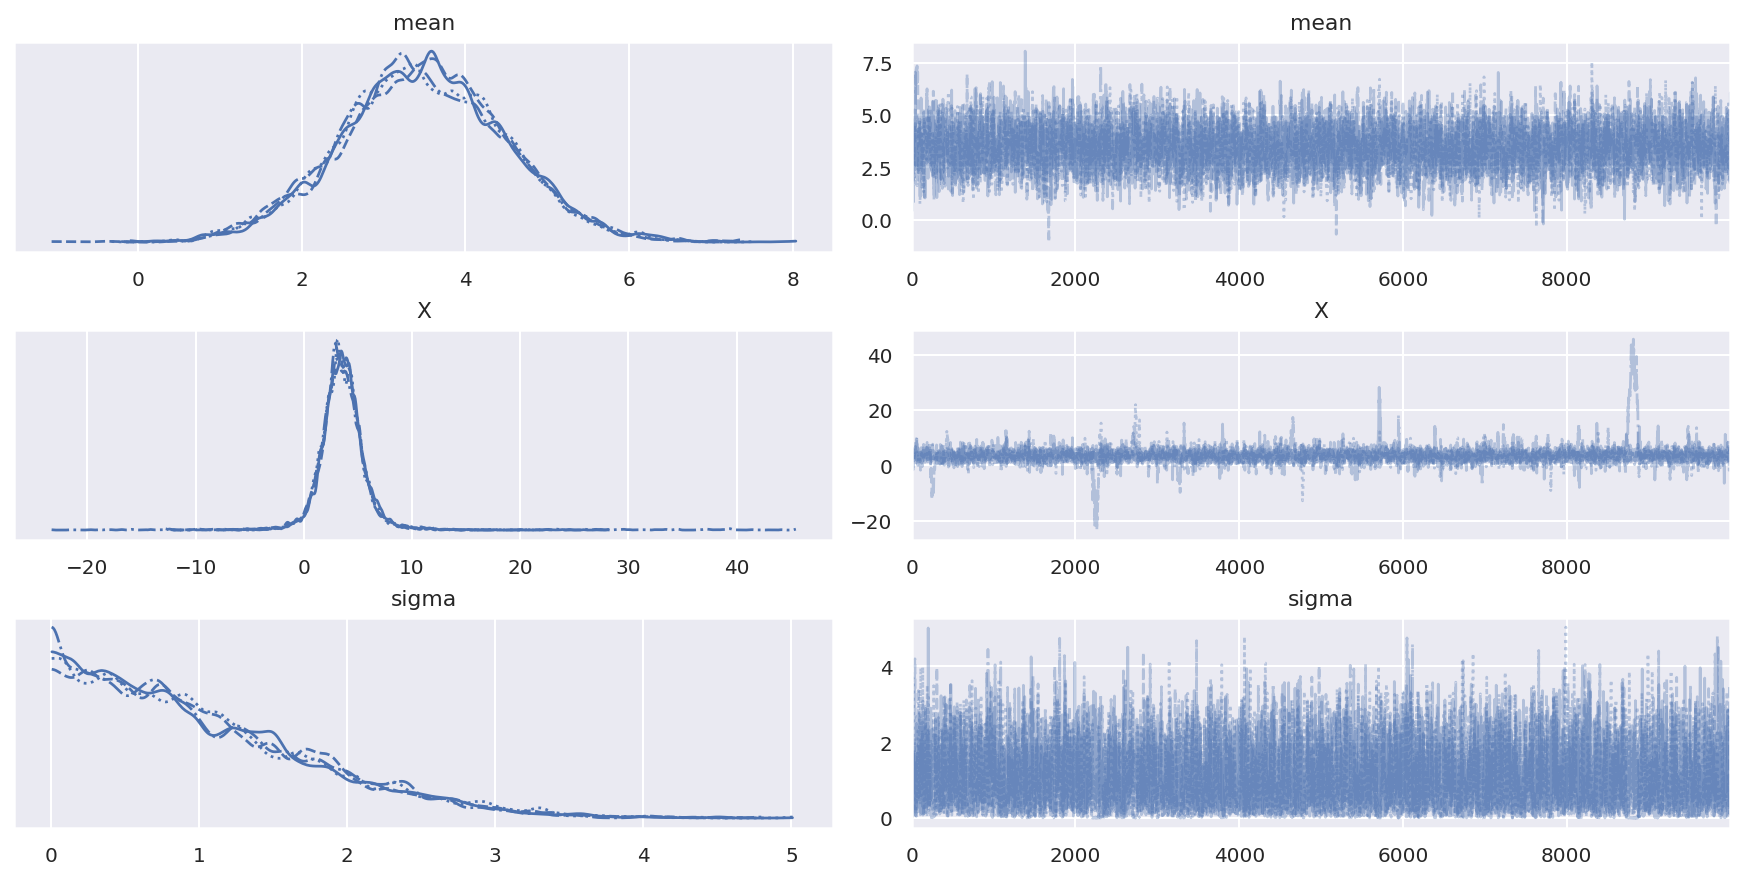

In [59]:
# fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace)
fig.tight_layout()
# fig.savefig("ch16-dependent-rv-sample-trace.png")
# fig.savefig("ch16-dependent-rv-sample-trace.pdf")

## Posterior distributions

In [17]:
mu = 2.5
s = 1.5

In [18]:
data = stats.norm(mu, s).rvs(100)

In [19]:
with mc.Model() as model:
    mean = mc.Normal('mean', 6.0, tau=1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', tau=4.0 * np.sqrt(np.pi/2)) # true 1.5

    X = mc.Normal('X', mean, tau=1/sigma**2, observed=data)

In [20]:
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution]

In [21]:
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(1000, start=start, step=step)
    # step = mc.NUTS()
    # trace = mc.sample(10000, start=start, step=step)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


/tmp/ipykernel_5184/3075617199.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = mc.sample(1000, start=start, step=step)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 120 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [22]:
start

{'mean': array(2.40532442),
 'sigma_log__': array(0.34352135),
 'sigma': array(1.40990362)}

In [23]:
model.vars

[mean ~ Normal, sigma_log__ ~ TransformedDistribution]

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/tmp/ipykernel_5184/1598250893.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


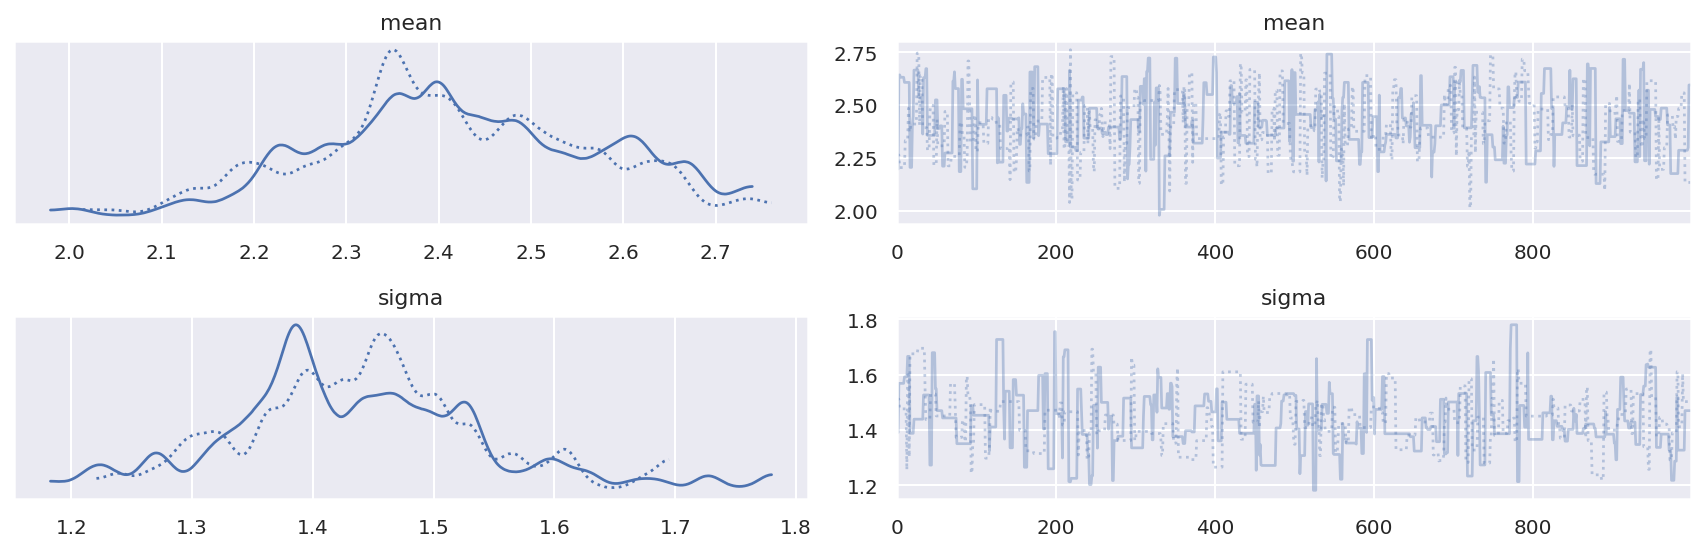

In [24]:
# fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.plot_trace(trace)
plt.tight_layout()
# fig.savefig("ch16-posterior-sample-trace.png")
# fig.savefig("ch16-posterior-sample-trace.pdf")

In [25]:
mu, trace.get_values('mean').mean()

(2.5, 2.417897777493602)

In [26]:
s, trace.get_values('sigma').mean()

(1.5, 1.4383039792669614)

/tmp/ipykernel_5184/2482795428.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  gs = mc.forestplot(trace)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


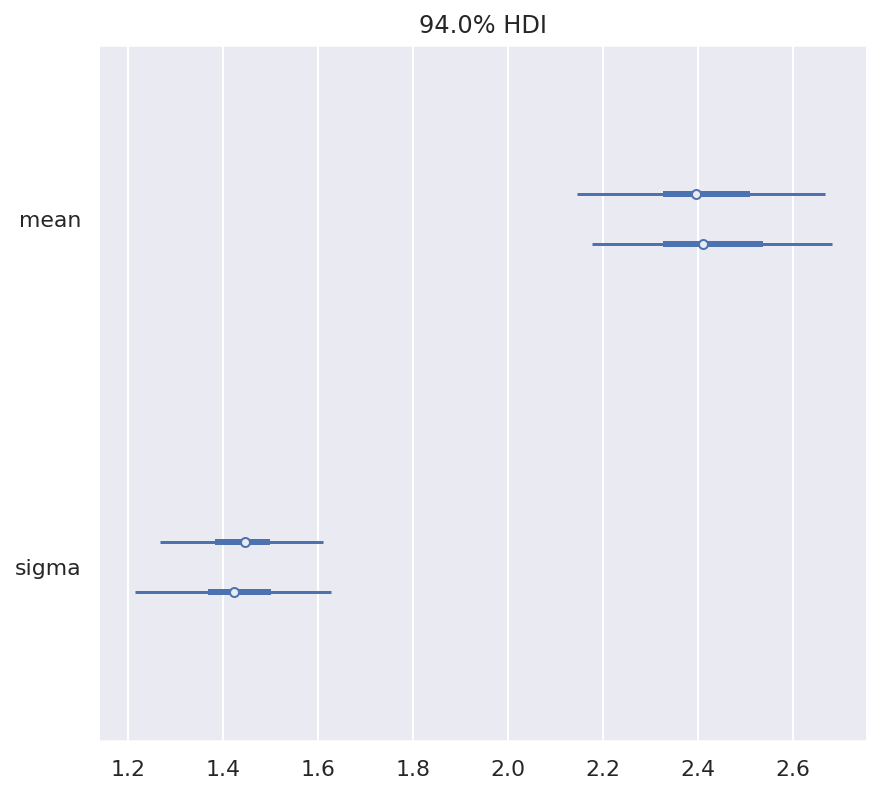

In [28]:
gs = mc.plot_forest(trace)
# plt.savefig("ch16-forestplot.pdf")

In [29]:
help(mc.summary)

Help on function summary in module arviz.stats.stats:

summary(data, var_names: Union[List[str], NoneType] = None, filter_vars=None, group=None, fmt: "Literal['wide', 'long', 'xarray']" = 'wide', kind: "Literal['all', 'stats', 'diagnostics']" = 'all', round_to=None, circ_var_names=None, stat_funcs=None, extend=True, hdi_prob=None, order: "Literal['C', 'F']" = 'C', index_origin=None, skipna=False, coords: Union[Dict[str, List[Any]], NoneType] = None, dims: Union[Dict[str, List[str]], NoneType] = None) -> Union[pandas.core.frame.DataFrame, xarray.core.dataset.Dataset]
    Create a data frame with summary statistics.
    
    Parameters
    ----------
    data: obj
        Any object that can be converted to an az.InferenceData object
        Refer to documentation of az.convert_to_dataset for details
    var_names: list
        Names of variables to include in summary. Prefix the variables by `~` when you
        want to exclude them from the summary: `["~beta"]` instead of `["beta"]` (s

In [31]:
mc.summary(trace)

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,2.418,0.146,2.173,2.687,0.007,0.005,386.0,325.0,1.00
sigma,1.438,0.102,1.225,1.611,0.007,0.005,231.0,221.0,1.01


## Linear regression

In [3]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [4]:
data = dataset.data[dataset.data.sex == 'M']

In [5]:
data = data[data.weight < 110]

In [6]:
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [7]:
model = smf.ols("height ~ weight + repwt", data=data)

In [8]:
result = model.fit()

In [9]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     22.61
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           1.80e-08
Time:                        20:31:43   Log-Likelihood:                -249.82
No. Observations:                  81   AIC:                             505.6
Df Residuals:                      78   BIC:                             512.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    150.4647      4.151     36.244      0.0

In [10]:
x = np.linspace(50, 110, 25)
v = np.linspace(60, 85 ,25)

In [11]:
y = result.predict({"weight": x, "repwt": v})

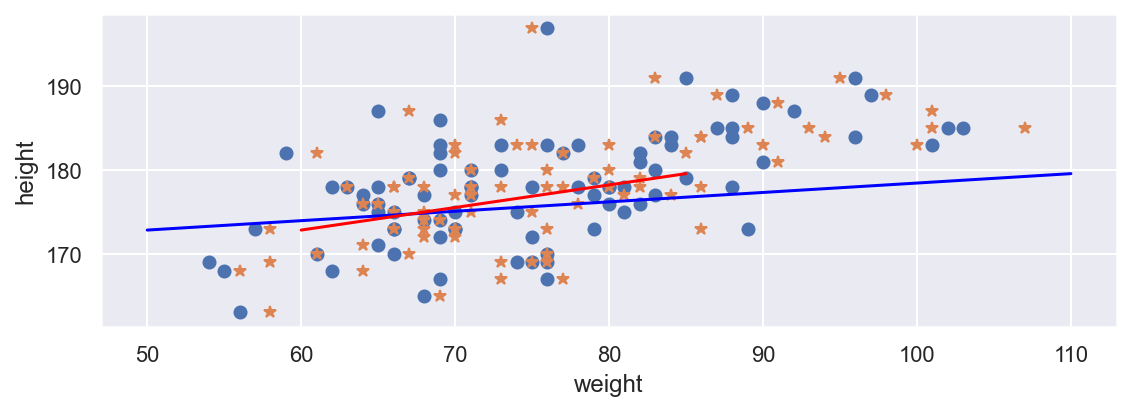

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(data.repwt, data.height, '*')
ax.plot(x, y, color="blue")
ax.plot(v, y, color="red")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()
# fig.savefig("ch16-linear-ols-fit.pdf")

In [13]:
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    # theta = mc.Normal('theta', 0, sd=1.5)

    height_mu = intercept + beta * data.weight
    # repwt_mu = intercept + theta * data.repwt
    # likelihood function
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)
    # mc.Normal('repwt', mu=repwt_mu, sd=sigma, observed=data.repwt)
    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x))
    # predict_repwt = mc.Normal('predict_repwt', mu=intercept + theta * v, sd=sigma, shape=len(v))

In [14]:
model.vars

[sigma_interval__ ~ TransformedDistribution,
 intercept ~ Normal,
 beta ~ Normal,
 predict_height ~ Normal]

In [ ]:
# help(mc.NUTS)

In [16]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, step, cores=1)

C:\Newprograms\Anaconda\envs\fm\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Newprograms\Anaconda\envs\fm\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


C:\Users\magda\AppData\Local\Temp/ipykernel_13500/2036288583.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = mc.sample(10000, step, cores=1)
Sequential sampling (2 chains in 1 job)
NUTS: [predict_height, beta, intercept, sigma]


Sampling 1 chain for 1_000 tune and 701 draw iterations (1_000 + 701 draws total) took 1290 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [72]:
model.vars

[sigma_interval__ ~ TransformedDistribution,
 intercept ~ Normal,
 beta ~ Normal,
 predict_height ~ Normal]

/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

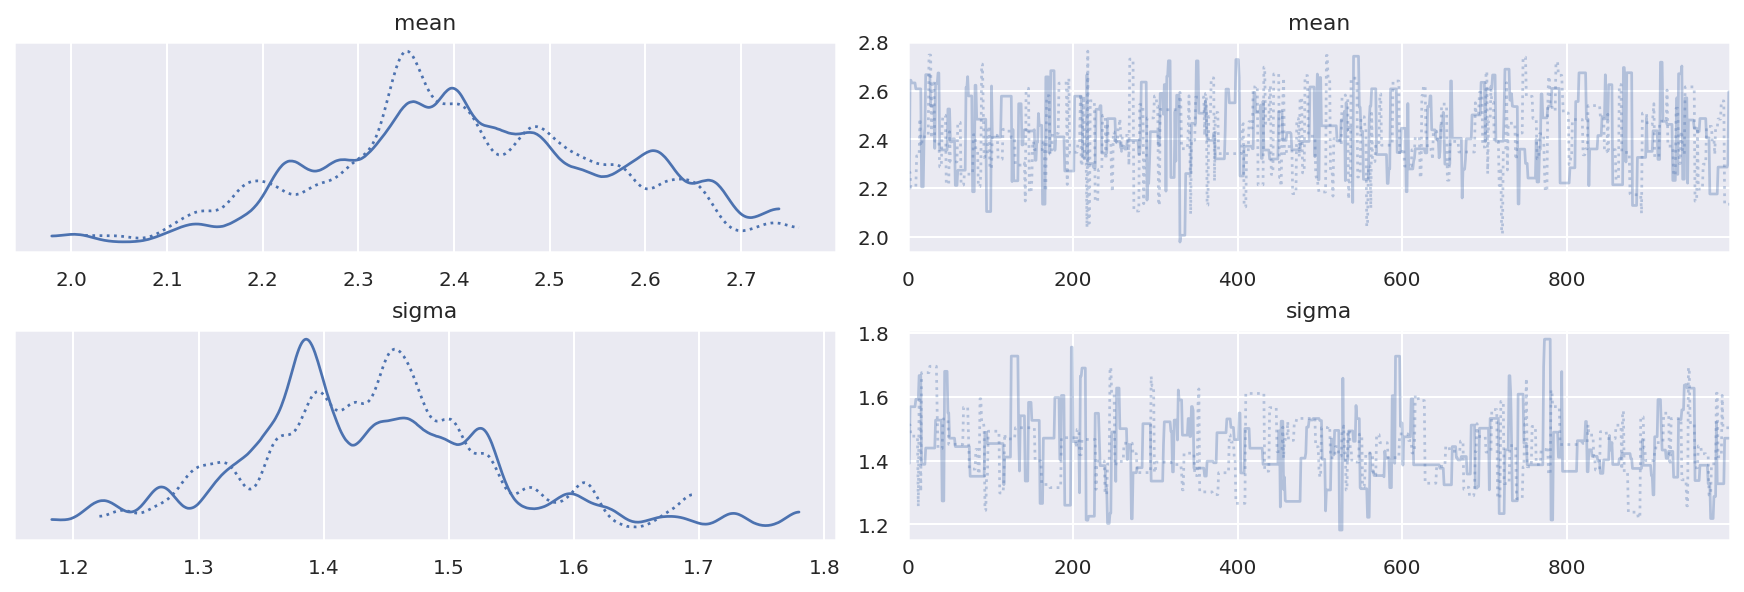

In [73]:
# fig, axes = plt.subplots(figsize=(8, 4), squeeze=False)
mc.plot_trace(trace)
# fig.savefig("ch16-linear-model-sample-trace.pdf")
# fig.savefig("ch16-linear-model-sample-trace.png")

In [75]:
intercept = trace.get_values("intercept").mean()
intercept

KeyError: 'intercept'

In [76]:
beta = trace.get_values("beta").mean()
# theta = trace.get_values("theta").mean()
print(beta)

KeyError: 'beta'

In [77]:
result.params

Intercept    150.464666
weight        -0.065797
repwt          0.427600
dtype: float64

In [ ]:
result.predict({"weight": 90})

In [ ]:
weight_index = np.where(x == 90)[0][0]

In [ ]:
trace.get_values("predict_height")[:, weight_index].mean()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
# fig.savefig("ch16-linear-model-predict-cut.pdf")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
# fig.savefig("ch16-linear-model-fit.pdf")
# fig.savefig("ch16-linear-model-fit.png")

In [83]:
with mc.Model() as model:
    mc.glm.GLM.from_formula('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/tmp/ipykernel_5184/3271942142.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = mc.sample(2000, step)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, weight, Intercept]


/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/dani/anaconda3/envs/fm/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encounte

ValueError: Not enough samples to build a trace.

In [ ]:
# fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace)
# fig.tight_layout()
# fig.savefig("ch16-glm-sample-trace.pdf")
# fig.savefig("ch16-glm-sample-trace.png")

## Multilevel model

In [ ]:
dataset = sm.datasets.get_rdataset("Davis", "carData")

In [ ]:
data = dataset.data.copy()
data = data[data.weight < 110]

In [ ]:
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)

In [ ]:
data.head()

In [ ]:
with mc.Model() as model:

    # heirarchical model: hyper priors
    #intercept_mu = mc.Normal("intercept_mu", 125)
    #intercept_sigma = 30.0 #mc.Uniform('intercept_sigma', lower=0, upper=50)
    #beta_mu = mc.Normal("beta_mu", 0.0)
    #beta_sigma = 5.0 #mc.Uniform('beta_sigma', lower=0, upper=10)
    
    # multilevel model: prior parameters
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    # priors
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    # model equation
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

In [ ]:
model.vars

In [ ]:
with model:
    start = mc.find_MAP()
    # hessian = mc.find_hessian(start)
    step = mc.NUTS()
    trace = mc.sample(5000, step, start=start)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta', 'error'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-multilevel-sample-trace.pdf")
fig.savefig("ch16-multilevel-sample-trace.png")

In [ ]:
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)

In [ ]:
intercept = trace.get_values('intercept').mean()

In [ ]:
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [ ]:
beta = trace.get_values('beta').mean()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png")

In [ ]:
trace.get_values('error').mean()

# Version

In [ ]:
%reload_ext version_information

In [ ]:
%version_information numpy, pandas, matplotlib, statsmodels, pymc3